# 1. Реализуем высокочастотную фильтрацию на основе ядра Гаусса

In [10]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

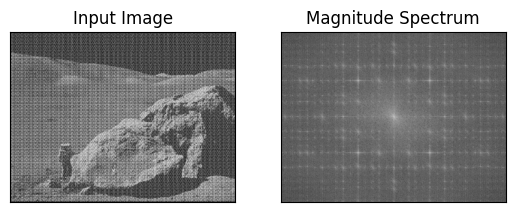

In [11]:
image = cv.imread("periodic_noise.jpg", cv.IMREAD_GRAYSCALE)

dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

plt.subplot(121), plt.imshow(image, cmap="gray")
plt.title("Input Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(magnitude_spectrum, cmap="gray")
plt.title("Magnitude Spectrum"), plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
def gaussian_filter(shape, sigma, is_high = True):
    rows, cols = shape
    hrow, hcol = rows // 2, cols // 2
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))

    gauss_mask = np.exp(-((x - hcol)**2 + (y - hrow)**2) / (2 * sigma**2))

    if is_high:
        return 1 - gauss_mask
    else:
        return gauss_mask

In [13]:
sigma = 30
mask_gaus = gaussian_filter(image.shape, sigma)

dft_shift = dft_shift * mask_gaus[:, :, np.newaxis]
image_idft = cv.idft(np.fft.ifftshift(dft_shift))
image_idft = cv.magnitude(image_idft[:, :, 0], image_idft[:, :, 1])

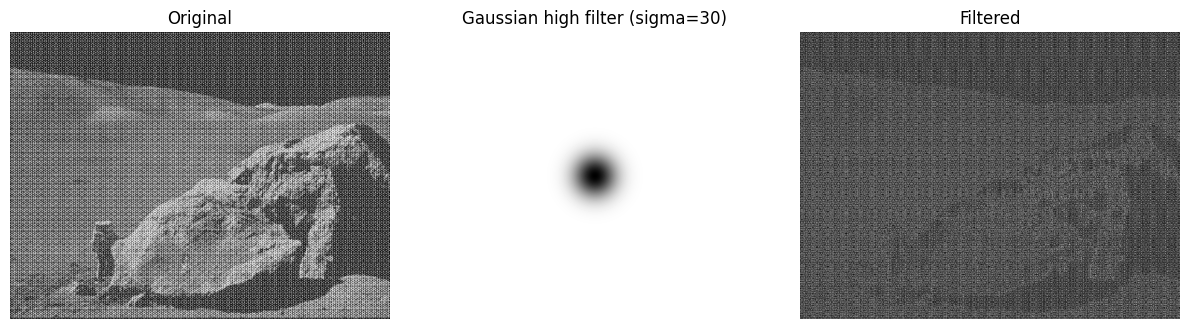

In [ ]:
images = {
    "Оригинал": image,
    f"High фильтр (sigma: {sigma})": mask_gaus,
    "Фильтр": image_idft,
}

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

col = 0
for col, (key, img) in enumerate(images.items()):
    axs[col].imshow(img, cmap="gray")
    axs[col].set_title(key)
    axs[col].axis("off")

plt.tight_layout()
plt.show()

# 2. Реализуем удаление периодического шума

In [15]:
from skimage.feature import peak_local_max

In [16]:
def periodic_noise_deletion(img):
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    local_maxum = peak_local_max(magnitude_spectrum, min_distance=15, threshold_abs=200)

    mask = np.copy(dft_shift)
    mask[:, :, :] = 1

    rows, cols = img.shape
    hrow, hcol = rows // 2, cols // 2
    for i in local_maxum:
        r = np.int32(((i[0] - hrow)**2 + (i[1] - hcol)**2) ** (1 / 2))
        cv.circle(mask, (hrow, hcol), r, (0, 0))

    dft_shift = dft_shift * mask
    image_idft = cv.idft(np.fft.ifftshift(dft_shift))
    image_idft = cv.magnitude(image_idft[:, :, 0], image_idft[:, :, 1])

    return image_idft

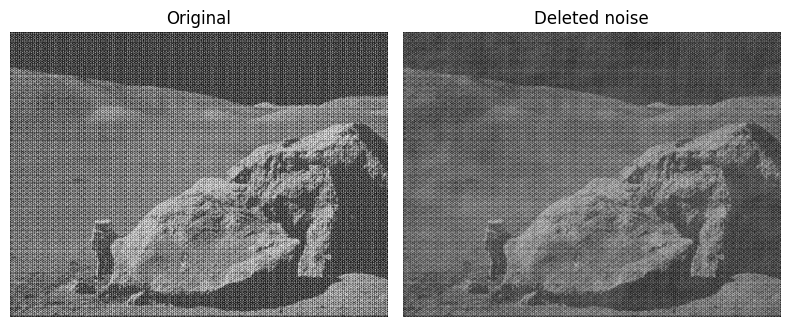

In [ ]:
images = {
    "Оригинал": image,
    "Без шума": periodic_noise_deletion(image),
}

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

col = 0
for col, (key, img) in enumerate(images.items()):
    axs[col].imshow(img, cmap="gray")
    axs[col].set_title(key)
    axs[col].axis("off")

plt.tight_layout()
plt.show()